# Análise monocanal

Neste notebook estamos concentrados no problema da deconvolução supervisionada usando a anállise de "monocanal". Neste sentido, espera-se deconnvoluir uma imagem borrada e recuperar o kernel de borramento a partir da minimização do erro de reconstrução. Como neste caso tem-se apenas um canal para a reconstrução da imagem, o erro minimizado é a reconstrução supervisionada, ou seja, utiliza-se a imagem original como referência. A equação utilizada pode ser observada abaixo:

\begin{equation}
    \min_{K} \mathcal{L}(X, K, Y, \lambda) = \min_{K} ||K X - Y||_{2} + \lambda ||K||_2
\end{equation}

Em que as matrizes $X$, $K$ e $Y$ representam respectivamente as transformadas de Fourier da imagem original, do kernel de borramento e da imagem borrada.

In [1]:
# Imports para uso geral
import numpy as np
import scipy.fftpack as fft
import cv2
from matplotlib import pyplot as plt
from scipy import signal, linalg

## Funções úteis

In [2]:
#---------------------------------------
# Módulo de funções de pré-processamento
#---------------------------------------

# Função de estimação de PSNR
def calc_psnr (ref_img, lat_img):
    '''Função de estimação de PSNR de uma determinada imagem latente
       
       Relação de inputs:
        1 - ref_img: Imagem de referência
        2 - lat_img: Imagem latente para estimação da grandeza'''
    
    # Confere se as dimensões das imagens são adequadas e as normalizam
    if ref_img.shape != lat_img.shape:
        raise Exception("Imagens de dimensões diferentes, averiguar ocorrido.")
    
    MSE = np.mean((ref_img - lat_img)**2)
    MAX = np.max(ref_img) #1.
    if MSE == 0:
        return 100
    
    PSNR = 20 * np.log10(MAX / np.sqrt(MSE))
    return PSNR

# Função de amostragem de floats diferentes entre si
def sample_floats (lo, hi, k=1):
    '''Função de escolha de números de ponto flutuante
       diferentes. Essa função será utilizada para a 
       determinação do desvio padrão dos canais gaussianos.
       
       Relação de inputs:
        1 - lo: Limite inferior
        2 - hi: Limite superior
        3 - k: Número de amostras'''
    
    ret  = np.zeros(k)
    seen = set()
    for ii in range(k):
        x = np.random.uniform(lo, hi)
        while x in seen:
            x = np.random.uniform(lo, hi)
        
        seen.add(x)
        ret[ii] = x
    
    return ret

# Função de determinação de kernel gaussiano
def gen_gaussian_kernel (size, sigma, im_shape, param=3):
    '''Função de criação de kerneis gaussianos de determinado
       tamanho e variância
       
       Relação de inputs:
        1 - size: Dimensão de kernel (quadrado - ímpar)
        2 - sigma: Desvio padrão do kernel'''
    
    # Verifica se o tamanho em questão é ímpar
    if size % 2 == 0:
        raise Exception("Tamanho de kernel não ímpar")
    
    # Criação de fase aleatória para o sistema 
    ph_x, ph_y = np.random.choice(
        np.arange(-param, param), size=2
    )
    
    # Definição offsets e índices geradores
    x0 = ((size + 1) / 2) - 1 + ph_x
    y0 = ((size + 1) / 2) - 1 + ph_y
    x  = np.arange(size)
    
    # Cálculo de gaussiana unidimensional e matriz
    gx  = np.exp(-(x - x0)**2 / (2 * sigma)**2)
    gy  = np.exp(-(x - y0)**2 / (2 * sigma)**2)
    G   = np.outer(gx, gy)
    G  /= np.sum(G)
    p_w = im_shape - 1
    G   = np.pad(G, pad_width=p_w)
    return G

# Função para regularização de imagens
def reg_vals (Mat):
    '''Função de adequação de valores NaN e inf 
       em matrizes do tipo numpy.
       Relação de inputs:
        1 - Mat: Matriz com valores a serem regularizados.'''
    
    # Localiza e regulariza elementos NaN e inf
    idxs = np.isnan(Mat) + np.isinf(Mat)
    if len(idxs) > 0:
        tmp = np.zeros(
            np.count_nonzero(idxs), 
            dtype = complex
        )
        Mat[idxs] = tmp
        max_val   = np.max(Mat)            # Teste
        Mat[idxs] = max_val * np.ones(     # Teste
            np.count_nonzero(idxs),
            dtype = complex
        )

    return Mat

## Leitura da imagem e borramento

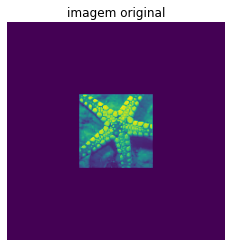

---------------------------

PSNR da imagem borrada: 20.285569645487385
Potência do filtro: 3.5704756793264507


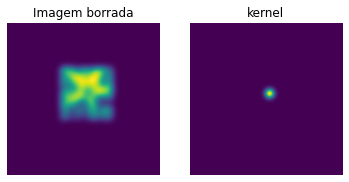

---------------------------


In [3]:
#---------------------------------------------------
# Módulo de borramento de imagem e criação de canais
#---------------------------------------------------

# Leitura da imgem original
im   = cv2.imread('./starfish.jpeg', cv2.IMREAD_GRAYSCALE)
im   = cv2.resize(im, (81, 81))
s_fx = fft.next_fast_len(im.shape[0])
s_fy = fft.next_fast_len(im.shape[1])
im   = cv2.resize(im, (s_fx, s_fy))

# Criação dos n canais gaussianos de forma iterativa
size_k  = min(im.shape)  # 3
lo, hi  = (1, size_k/20) #/10)

# zero padding imagem e borrão
sig       = sample_floats(lo, hi, k=1)[0]
ker       = gen_gaussian_kernel(size_k, sig, size_k, param=np.int32(size_k/10))
ker      /= linalg.norm(ker)
im        = np.pad(im, pad_width=(size_k-1))

# Aplicação dos diferentes kerneis na imagem de referência
blured_im = signal.convolve2d(im, ker, mode="same")
        
#---------------------------------------------------------
# Impressão das imagens obtidas em comparação com original
#---------------------------------------------------------

plt.imshow(im)
plt.title("imagem original")
plt.axis("off")
plt.show()
print("---------------------------")
print()
print(f"PSNR da imagem borrada: {calc_psnr(im / linalg.norm(im), blured_im / linalg.norm(blured_im))}")
print(f"Potência do filtro: {sig}")

# Impressão dos resultados preliminares iniciais
plt.subplot(1, 2, 1)
plt.imshow(blured_im)
plt.title("Imagem borrada")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(ker)
plt.title("kernel")
plt.axis("off")
plt.show()
print("---------------------------")

## Funções auxiliares para a descida de gradiente

Nesse bloco estão implementadas as funções auxiliares à descida de gradiente

In [4]:
#-----------------------------
# Funções de custo e Jacobiana
#-----------------------------

def lag (X, K, Y, lbda=0):
    '''Função de custo utilizada para minimização do processo
       baseada no erro de reconstrução e penalização da norma l2.
       Relação de inputs:
        1 - X: TF da imagem original;
        2 - K: TF do kernel estimado;
        3 - Y: TF da imagem borrada;
        4 - lbda:  Parâmetro de peso para penalização da norma l2.'''
    
    tmp  = np.multiply(X, K)
    tmp  = reg_vals(tmp)
    lag  = linalg.norm(tmp - Y)**2 
    lag += lbda * linalg.norm(K)**2
    return lag

def lag_jac (X, K, Y, lbda=0):
    '''Jacobiano da função de custo usada pela descida de
       gradiente.
       Relação de inputs:
        1 - X: TF da imagem original;
        2 - K: TF do kernel estimado;
        3 - Y: TF da imagem borrada;
        4 - lbda:  Parâmetro de peso para penalização da norma l2.'''
    
    err = np.multiply(X, K) - Y
    jac = 2 * (np.multiply(err, np.conj(X)) + lbda * np.conj(K))
    return jac

#------------------------------------------------------
# Função de busca de Armijo para tamanho ótimo de passo
#------------------------------------------------------

def armijo (X, K, Y, d, alpha=0.45, gamma=0.7, lbda=0):
    '''Função de estimação de tamanho de passo suficientemente
       bom para cada iteração da descida de gradiente, utiliza-se
       como parâmtro a seguinte relação:
       
           \mu \in R: f(x + \mu*d) < f(x) + \mu * \alpha * d * \nabla f(x)
       
       Relação de inputs:
        1 - X: TF da imagem original;
        2 - K: TF do kernel estimado;
        3 - Y: TF da imagem borrada;
        4 - d: direção da busca exata;
        5 - alpha: Parâmetro de tolerância da busca de armijjo;
        6 - gamma: Parâmetro de atualização do comprimento do passo;
        7 - lbda:  Parâmetro de peso para penalização da norma l2.'''
    
    # Inicialização das constantes usadas
    mu  = 1
    gx  = lag_jac(X, K, Y, lbda=lbda)
    gd  = np.multiply(np.conj(gx), d)
    f0  = lag(X, K, Y, lbda=lbda)
    ii  = 0
    
    # Inicialização da parte variável da função
    f   = lag(X, K + mu * d, Y, lbda=lbda)
    
    # Loop principal
    while f >= f0 + mu * alpha * linalg.norm(gd):
        # Salvaguarda 1
        if ii % 250 == 0:
            mu = linalg.norm(d) / 100

        mu = mu * gamma
        f  = lag(X, K + mu * d, Y, lbda=lbda)
        ii = ii + 1
        
        # Salvaguarda 2
        if ii == 1000:
            mu = 1e-3
            break
    
    return mu

## Descida de gradiente

Nesta etapa utiliza-se a descida de gradiente com as TF's das imgens (evitando a sobrecarga computacional da utilização da convolução no domínio da imagem.

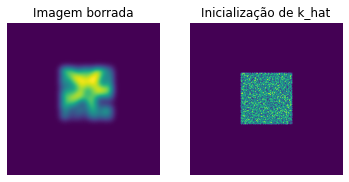

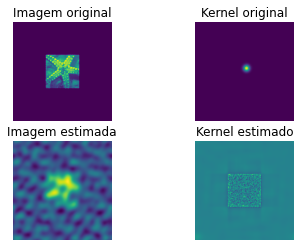

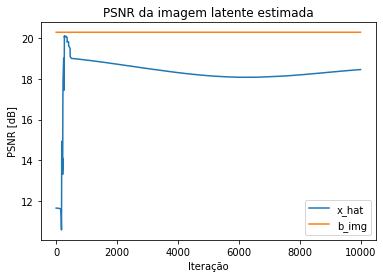

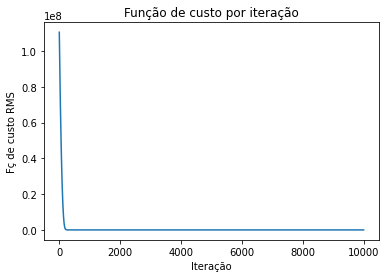

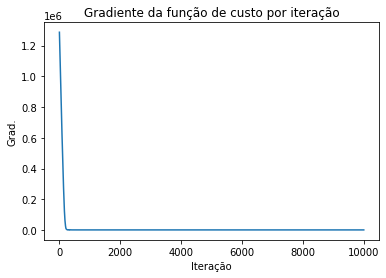

In [6]:
#-------------------------------------------------------------------------
# Implementação da descida de gradiente no domínio transformado para a FFT
#-------------------------------------------------------------------------

# Aplicação das transformadas
X = fft.fft2(
    im / linalg.norm(im)
)
Y = fft.fft2(
    blured_im / linalg.norm(blured_im)
)

# Geração aleatória de kernel para estimação
k0    = np.random.rand(81, 81)
k0    = np.pad(k0, pad_width=size_k - 1)
k_tmp = k0 / linalg.norm(k0)
K     = fft.fft2(k_tmp)

# Cálculo da condição de erro e tolerância
eps  = 1e-5
lbda = 5
cond = lag(X, K, Y, lbda=lbda)
it   = 0
max_it = 1e4     #1000
deb_f  = False   #True

# Inicialização de variáveis de qualidade a serem plotadas por iteração
PSNR_ker = np.zeros(np.int32(max_it))
PSNR_img = np.zeros(np.int32(max_it))
cond_vec = np.zeros(np.int32(max_it))
grad_vec = np.zeros(np.int32(max_it))

# Loop principal para a descida de gradiente
while (it < max_it) and (cond > eps):
    try:
        # Cálculo do gradiente do erro de reconstrução
        jac   = lag_jac(X, K, Y, lbda=lbda)
        n_jac = linalg.norm(jac)          # TESTE
        if n_jac > 1e-6:                  # TESTE
            jac = jac / n_jac             # TESTE
        
        mu  = armijo(X, K, Y, -1 * jac, alpha=0.15, lbda=lbda)
        K   = K - mu * jac
        #K  /= linalg.norm(K)
        #k_tmp  = fft.ifft2(K).real
        #k_tmp /= linalg.norm(k_tmp)
        #K      = fft.fft2(k_tmp)

        # Atualização do contador de iterações e de condição de erro
        cond = lag(X, K, Y, lbda=lbda)
        
        # Atualização de vetores com variáveis do sistema a serem plotadas
        cond_vec[it] = cond
        grad_vec[it] = n_jac
        
        # Cálculo de grandezas inversas para avaliação do desempenho de qualidade
        x_hat        = fft.ifft2(np.divide(Y, K)).real
        x_hat       /= linalg.norm(x_hat)
        k_hat        = fft.ifft2(K).real
        k_hat       /= linalg.norm(k_hat)
        PSNR_ker[it] = calc_psnr(ker / linalg.norm(ker), k_hat)
        PSNR_img[it] = calc_psnr(im  / linalg.norm(im),  x_hat)
        it          += 1

        # DEBUG
        if deb_f:    
            print("------------------------------")
            print(f"Iteração: {it}")
            print(f"mu   = {mu}")
            print(f"cond = {cond}")
            print(f"jac  = {linalg.norm(jac)}")
            print(f"PSNR do kernel:          {np.round(PSNR_ker[it - 1], 3)} dB")
            print(f"PSNR da imagem estimada: {np.round(PSNR_img[it - 1], 3)} dB")
            print(f"PSNR da imagem borrada:  {np.round(calc_psnr(im / linalg.norm(im), blured_im / linalg.norm(blured_im)), 3)} dB")
            #plt.subplot(2, 2, 1)
            #plt.imshow(im)
            #plt.axis("off")
            #plt.title("Imagem original")
            #plt.subplot(2, 2, 2)
            #plt.imshow(ker)
            #plt.axis("off")
            #plt.title("Kernel original")
            #plt.subplot(2, 2, 3)
            #plt.imshow(x_hat)
            #plt.axis("off")
            #plt.title("Imagem estimada")
            #plt.subplot(2, 2, 4)
            #plt.imshow(k_hat)
            #plt.axis("off")
            #plt.title("Kernel estimado")
            #plt.show()
    
    except Exception as e:
        print("Erro: Solução divergente:")
        print(e)
        break
        
# Cálculo da imagem latente
x_hat  = fft.ifft2(np.divide(Y, K)).real
x_hat /= linalg.norm(x_hat)
k_hat  = fft.ifft2(K).real
k_hat /= linalg.norm(k_hat)

# Impressão do kernel aleatório inicial
plt.subplot(1, 2, 1)
plt.imshow(blured_im)
plt.axis("off")
plt.title("Imagem borrada")
plt.subplot(1, 2, 2)
plt.imshow(k0)
plt.axis("off")
plt.title("Inicialização de k_hat")
plt.show()

# Impressão das imagens estimadas
plt.subplot(2, 2, 1)
plt.imshow(im)
plt.axis("off")
plt.title("Imagem original")
plt.subplot(2, 2, 2)
plt.imshow(ker)
plt.axis("off")
plt.title("Kernel original")
plt.subplot(2, 2, 3)
plt.imshow(x_hat)
plt.axis("off")
plt.title("Imagem estimada")
plt.subplot(2, 2, 4)
plt.imshow(k_hat)
plt.axis("off")
plt.title("Kernel estimado")
plt.show()

# Impressão dos gráficos para medida de desempenho do sistema
t      = np.arange(it)
b_psnr = calc_psnr(im / linalg.norm(im), blured_im / linalg.norm(blured_im))
#plt.subplot(2, 1, 1)
plt.plot(t, PSNR_img[:it], label="x_hat")
plt.plot(t, b_psnr * np.ones_like(t), label="b_img")
plt.xlabel("Iteração")
plt.ylabel("PSNR [dB]")
plt.title("PSNR da imagem latente estimada")
plt.legend()
#plt.xticks()
#plt.subplot(2, 1, 2)
#plt.plot(t, PSNR_ker[:it])
#plt.title("PSNR do kernel estimado")
plt.show()

# Impressão dos gráficos de condição e gradiente (para verificação da descida)
plt.plot(t, cond_vec)
plt.title("Função de custo por iteração")
plt.xlabel("Iteração")
plt.ylabel("Fç de custo RMS")
plt.show()
plt.plot(t, grad_vec)
plt.title("Gradiente da função de custo por iteração")
plt.xlabel("Iteração")
plt.ylabel("Grad.")
plt.show()